In [previous](https://the-fonz.gitlab.io/posts/array-databases/) [posts](https://the-fonz.gitlab.io/posts/interpolation/) we explored how to work efficiently with [xarray](xarray.pydata.org/) and geospatial meteorological data, and while it would be possible to throw in extra adjectives to make that sound even more impressive, let's focus on the storage of this data.

<!-- TEASER_END -->

[Zarr](xarray.pydata.org/) is a relatively new storage format for multidimensional array data that puts every "array chunk" in a separate file/blob, allowing many different encoding/compression schemes within that blob while giving up random reads, which is fine as for (cloud) blob storage the latency overhead of getting a blob is relatively high, but bandwidth high as well so better just download the whole blob in one go. For google's cloud storage, these prices can be expected:

| Storage type                                                               | Price [$/GB/month] | Retrieval cost [GB] |
|---|---|---|
| [Standard](https://cloud.google.com/storage/docs/storage-classes#standard) | .02    | 0    |
| [Nearline](https://cloud.google.com/storage/docs/storage-classes#nearline) | .01    | 0.01 |
| [Coldline](https://cloud.google.com/storage/docs/storage-classes#coldline) | .004   | 0.02 |
| [Archive](https://cloud.google.com/storage/docs/storage-classes#archive)   | .0012  | 0.05 |

Please note that these prices are approximate and may vary by region and may become cheaper over time (I remember standard storage costing .026 \\$/GB/month not too long ago, can still see that price in some examples). Minimum storage duration is 30 days for nearline and 90 days for coldline, and there is a small cost for operations (delete/move etc) but that is usually negligible. Availability SLAs are also best for standard storage and go down a bit for the cold storage classes. Also, I assume the data is used mostly in gcloud datacenters, as egress cost of ~.10 \\$/GB will quickly eclipse any storage cost.

From the table above, it's easy to deduct that nearline storage is cheaper than standard when downloaded less than once a month, while coldline is cheaper when downloaded at most once every 1.5 months, and archive at most once every 3 months. It can be a nice trick to set a lifecycle policy on a cloud storage bucket that moves objects to nearline after 1 month.

This compares to about .05 \\$/GB/month for block storage on HDDs, up to .17 \\$/GB/month for block storage on SSDs, so blob storage is at least 2.5x cheaper. Also, it's difficult to mount block storage for concurrent reading/writing as one would need compute on top of the storage that runs something like NFS which allows connection over the network. This shows why it's so important to have good support for blob storage in file formats for storing huge amounts of numeric array data.

I want to know what the best preprocessing steps (quantization?) are, what the compresson algorithm is with the best tradeoff of speed/compression, and if byte shuffling yields significant benefits.

## The data
We use ERA5 again as it's a representative set of meteo data, but this time downloaded from the awesome Pangeo cloud storage buckets. Make sure you use a gcloud account with billing enabled, as it's requester-pays on these buckets. See [the instructions here](https://catalog.pangeo.io/browse/master/atmosphere/era5_hourly_reanalysis_single_levels_sa/).

In [1]:
!pip install -q intake intake-xarray gcsfs

In [2]:
import os
import tempfile
from datetime import datetime
from time import time
from pathlib import Path

import numpy as np
from intake import open_catalog
from itertools import permutations
import matplotlib.pyplot as plt
from numcodecs import blosc
from zarr.codecs import Blosc
# Use nice seaborn mpl theme
import seaborn as sns
sns.set_theme()

# Make fair comparisons with compression algorithms later (some use multiple threads by default)
blosc.set_nthreads(1);

In [3]:
# See instructions at https://catalog.pangeo.io/browse/master/atmosphere/era5_hourly_reanalysis_single_levels_sa/
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/atmosphere.yaml")
ds  = cat["era5_hourly_reanalysis_single_levels_sa"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 350640)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    asn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ptype      (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tcc        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tcrw       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-20 05:15:01 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [4]:
ds.t2m.data

dask.array<zarr, shape=(350640, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>

Now we'll load a subset of this data into memory. As we can see above, the dataset is only chunked in time, per 31 timesteps. We'll slice to just one chunk to be able to download it quickly.

In [5]:
ds2 = ds.isel(time=slice(0, 31))
ds2.t2m.data

dask.array<getitem, shape=(31, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>

In [6]:
%%time
ds2.load()

CPU times: user 24.9 s, sys: 13.1 s, total: 38 s
Wall time: 1min 22s


<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 31)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-01-02T06:00:00
Data variables:
    asn        (time, latitude, longitude) float32 0.88000053 ... 0.850001
    d2m        (time, latitude, longitude) float32 240.97255 ... 244.83789
    e          (time, latitude, longitude) float32 nan nan ... 4.9493974e-07
    mn2t       (time, latitude, longitude) float32 nan nan ... 248.4101 248.4101
    mx2t       (time, latitude, longitude) float32 nan nan ... 248.46516
    ptype      (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    ro         (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    sd         (time, latitude, longitude) float32 0.0 0.0 0.0 ... 10.0 10.0
    sro        (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    ssr        (time, latitude, longitude) float32 nan nan ... 268708.75
    t2m        (time, latitude, longitude) float32 244.07776 ... 248.47702
    tcc        (time, latitude, longitude) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0
    tcrw       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tp         (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    tsn        (time, latitude, longitude) float32 245.32692 ... 246.29123
    u10        (time, latitude, longitude) float32 0.01948136 ... 0.52920276
    v10        (time, latitude, longitude) float32 -0.024540722 ... 0.22564238
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-20 05:15:01 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [7]:
ds2.t2m.encoding

{'chunks': (31, 721, 1440),
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'missing_value': -32767.0,
 '_FillValue': -32767,
 'scale_factor': 0.0016946343655403098,
 'add_offset': 265.9707255587938,
 'dtype': dtype('int16')}

## Establishing baselines

We see above that there is already some quantization used by setting a scale factor and offset and converting from float32 to int16. (This is xarray functionality, not zarr/numcodecs filters.) In addition, the Blosc metacompressor is used, which can do byte-shuffling. This is very efficient for numerical data, as all first bytes are first compressed, then all second bytes etc., and these are much more alike than the subsequent bytes in an int or float. Let's see what that results in, in terms of disk usage.

In [8]:
# Track experiments for plotting later
results = []

def dirsize_mb(p: str):
    return sum(f.stat().st_size for f in Path(p).glob('**/*'))/2**20

def experiment(name, encoding, transpose_order=None, record=True):    
    with tempfile.TemporaryDirectory() as tmpdir:
        t0 = time()
        if transpose_order:
            ds2.transpose(*transpose_order).to_zarr(tmpdir, encoding=encoding)
        else:
            ds2.to_zarr(tmpdir, encoding=encoding)
        t = time() - t0
        size = dirsize_mb(tmpdir)
    print(f"Total size {name} {size:.3f}Mi")
    if record:
        results.append((name, size, t))

experiment("uncompressed float32", {k: {"compressor": None} for k in ds.data_vars.keys()})
experiment("compressed float32", {k: {
    "compressor": Blosc(cname='lz4', clevel=5, shuffle=Blosc.SHUFFLE, blocksize=0),
    "filters": None,
    "dtype": np.float32
} for k in ds.data_vars.keys()})
experiment("compressed float32 noshuffle", {k: {
    "compressor": Blosc(cname='lz4', clevel=5, shuffle=Blosc.NOSHUFFLE, blocksize=0),
    "filters": None,
    "dtype": np.float32
} for k in ds.data_vars.keys()})
experiment("compressed (original encoding)", None)

Total size uncompressed float32 2163.606Mi
Total size compressed float32 816.666Mi
Total size compressed float32 noshuffle 1066.917Mi
Total size compressed (original encoding) 468.758Mi


All right, our first data points! The total size is 2.2GB without any compression, .8GB with lossless compression, and finally we see that the efficient (lossy) quantization applied by Pangeo results in a compressed size of just ~.5GB. (That's why the download was faster than expected.)

Let's see what the compression ratio of different vars is.

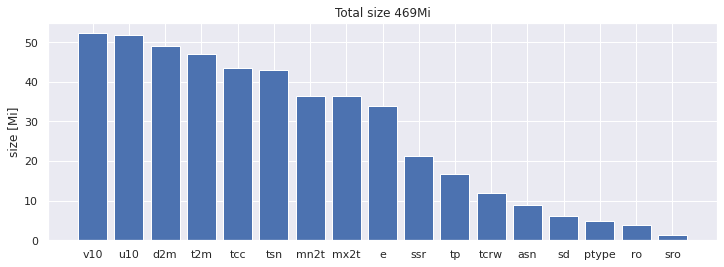

In [9]:
FIGWIDTH=12
    
with tempfile.TemporaryDirectory() as tmpdir:
    ds2.to_zarr(tmpdir)
    x = []
    y = []
    for vardir in Path(tmpdir).glob("*"):
        if os.path.basename(vardir) in ds2.data_vars:
            x.append(os.path.basename(vardir))
            y.append(sum(f.stat().st_size for f in vardir.glob("**/*")))
    plt.figure(figsize=(FIGWIDTH, 4))
    plt.title(f"Total size {round(sum(y)/2**20)}Mi")
    x, y = zip(*sorted(zip(x, y), key=lambda xy: xy[-1], reverse=True))
    plt.bar(x, np.array(y)/2**20)
    plt.ylabel("size [Mi]")
    plt.show()

Some variables, like "total precipitation" (tp), are 0 most of the time, thus compress much better. Others, like "2m temperature" (t2m) and "wind speed at 10m" (u/v10), always have some value and are always changing so are harder to compress.

## Quantization

What the Pangeo dataset does well, is to quantize the floats to fit in 16-bit (signed) integers. They basically use an offset and scale factor, probably based on the min/max values of the entire dataset, to fit it in this range. We can reduce this range so that compression is easier. Let's see what we can do.

In [10]:
def range_experiment(name, scale=1, dtype="int16", shuffle=True, cname="lz4", clevel=5, **kwargs):
    
    encoding = {}
    
    for k in ds2.data_vars.keys():
        v_min, v_max = np.nanmin(ds2[k].values), np.nanmax(ds2[k].values)
        
        encoding[k] = {
            "compressor": Blosc(cname=cname, clevel=clevel, shuffle=Blosc.SHUFFLE if shuffle else Blosc.NOSHUFFLE, blocksize=0),
            "filters": None,
            "missing_value": -32767.0,
            "_FillValue": -32767,
            "scale_factor": (v_max-v_min)/65536 * scale,
            "add_offset": v_min + (v_max-v_min)/2,
            "dtype": np.dtype(dtype)
        }

    experiment(name + f" level={clevel}", encoding, **kwargs)

range_experiment("no shuffle", shuffle=False)
range_experiment("quantized to int8", scale=256, dtype="int8")

for scale in [1, 10, 100, 256]:
    range_experiment(f"scale {scale} ({65536//scale} values)", scale=scale, transpose_order=('latitude', 'time', 'longitude'))

Total size no shuffle level=5 581.085Mi
Total size quantized to int8 level=5 180.651Mi
Total size scale 1 (65536 values) level=5 458.496Mi
Total size scale 10 (6553 values) level=5 345.582Mi
Total size scale 100 (655 values) level=5 234.144Mi
Total size scale 256 (256 values) level=5 182.050Mi


That does yield some benefit, but we give up a lot of resolution for a modest decrease in storage size. Let's continue and see what different compression libraries can do for us.

In [11]:
for clevel in [1,5]:
    for cname in blosc.list_compressors():
        range_experiment(cname, cname=cname, clevel=clevel)

Total size blosclz level=1 722.452Mi
Total size lz4 level=1 486.358Mi
Total size lz4hc level=1 438.979Mi
Total size snappy level=1 469.271Mi
Total size zlib level=1 408.904Mi
Total size zstd level=1 435.505Mi
Total size blosclz level=5 528.876Mi
Total size lz4 level=5 476.177Mi
Total size lz4hc level=5 423.128Mi
Total size snappy level=5 467.425Mi
Total size zlib level=5 392.028Mi
Total size zstd level=5 382.064Mi


## Results
Let's plot the results of our experiments so far, both the compressed total file size and the time it took to save.

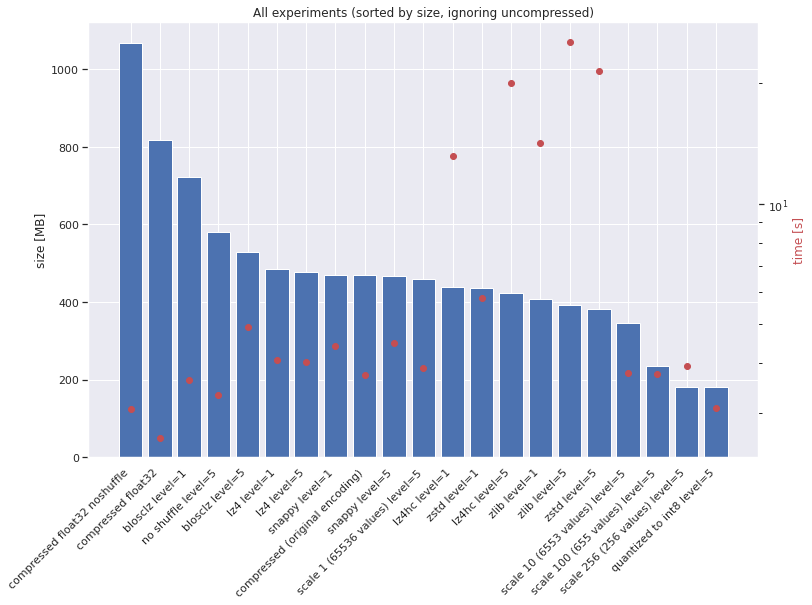

In [12]:
res = sorted(results, key=lambda x: x[1], reverse=True)[1:]

plt.figure(figsize=(FIGWIDTH, 8))
plt.title("All experiments (sorted by size, ignoring uncompressed)")
plt.xticks(range(len(res)), rotation=45, horizontalalignment="right")

ax1 = plt.gca()
ax1.set_ylabel("size [MB]")
ax2 = ax1.twinx()
ax2.set_ylabel("time [s]", color="r")
ax2.grid(False)
ax2.set_yscale("log")

for i, (name, size, t) in enumerate(res):
    ax1.bar(name, size, color="b")
    ax2.plot(i, t, 'ro', label=None)

plt.show();

This is not a proper benchmark, so the "compression time" numbers are not very reliable (they jump around a bit from one run to the next), take them with a grain of salt.

## Influence of dimension order

As a final optimization, I want to explore the order of the dimensions, as this data is 3-dimensional but saved as a 1-dimensional buffer of bytes. Numeric arrays that change little are easier to compress than arrays that change a lot from one value to the next.

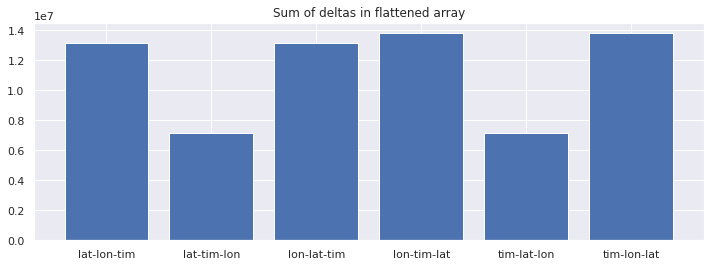

In [13]:
fig = plt.figure(figsize=(FIGWIDTH, 4))
plt.title("Sum of deltas in flattened array")
stats = []
labels = []

for coords in permutations(list(ds2.coords)):
    dst = ds2.t2m.transpose(*coords)
    label = "-".join(c[:3] for c in coords)
    plt.bar(label, np.abs(np.diff(dst.data.ravel())).sum(), label=label, color="b")

plt.show();

In [14]:
for coords in permutations(list(ds2.coords)):
    range_experiment(str(coords), transpose_order=coords, record=False)

Total size ('latitude', 'longitude', 'time') level=5 509.837Mi
Total size ('latitude', 'time', 'longitude') level=5 458.496Mi
Total size ('longitude', 'latitude', 'time') level=5 519.348Mi
Total size ('longitude', 'time', 'latitude') level=5 488.550Mi
Total size ('time', 'latitude', 'longitude') level=5 476.177Mi
Total size ('time', 'longitude', 'latitude') level=5 505.325Mi


As the data is a simple array when it is compressed, we want the slowest changing dimensions last so it is most efficiently compressed. We see the same trend in the plot, with longitude seeming to change most slowly, then time, then latitude. (This might be different for different datasets and resolutions.) The file sizes after compression seem to tell the same story.

Lessons learned:
- The byte shuffling that Blosc can do is very effective
- Quantizing a float32 by fitting its range in an int16 is very effective (more effective encodings can be designed for specific values, but it's hard to improve the effectiveness of this int16 quantization approach)
- Ordering the dimensions from fastest to slowest changing makes a significant difference
- Compression algorithms can yield some improvement, generally the Blosc default of lz4 at level 5 is quite effective and fast
- It might be interesting to test decompression speed, did not do that here